In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import gzip
import numpy as np
import os
import phate
import time

import pandas as pd

from collections import defaultdict
import itertools

# Interactive HTML tools
from ipywidgets import interact
import bokeh
import bokeh.io
from bokeh.io import push_notebook
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.palettes import Category20b
from bokeh.palettes import Category10

# Machine-learning and dimensionality reduction tools
import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA as PCA # We'll use this to check our implementation
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import MDS

# Notes

This notebook is intended for HRS data. The 1000G notebook was getting unwieldy. Basically, I would like to:
* Import PCs (already created by PLINK)
* Project to tSNE
* Subset and present data as desired.

QC reports on genotype data available here: https://hrs.isr.umich.edu/data-products/genetic-data/products#gdv1

# Define functions

In [2]:
# Define a function that will allow us to project using TSNE, given inputs and perplexities, and output the coordinates
def hrs_pc_tsne(in_data, plex, subset_group, save=False, subsetting=False):
    num_pcs = in_data.shape[1]
    temp_proj = TSNE(n_components=2, perplexity=plex).fit_transform(in_data)
    
    if save == True:
        if subsetting == True:
            np.savetxt('HRS_TSNE_' + subset_group + 'PC_' + str(num_pcs) + '_PLEX_' + str(plex), temp_proj)
        elif subsetting == False:
            np.savetxt('HRS_TSNE_PC_' + str(num_pcs) + '_PLEX_' + str(plex), temp_proj)
    
    return(temp_proj)

# Importing data

Import the principal components and any related auxiliary data.

In [3]:
# Note: PLINK command used to create cleaned HRS data 
# plink --bfile HRS --maf 0.05 --mind 0.1 --geno 0.1 --hwe 1e-6 --make-bed --out HRS_CLEAR
# Minor Allele Freq, Missing genotype rates (per-sample) Missing genotype rates (per-variant), Hardy-Weinberg equilibrium, 

# PLINK command used to create PCs
# plink --bfile HRS_CLEAR --pca [n]

# PLINK command used to create PCs for white-identified individuals in HRS
# plink --bfile HRS_CLEAR --pca [n] --keep hrs_subset_white.txt

hrs_data_dir = '/Users/alex/Documents/Ethnicity/HRS'

# Define the files we'll be using
aux_file = 'allIndivs_filtered.txt'
pc_files = ['plink.eigenvec_200','HRS_PCA_black.eigenvec','HRS_PCA_hispanic.eigenvec','HRS_PCA_white.eigenvec']
pc_file = 'plink.eigenvec_200'
#pc_file = 'HRS_PCA_black.eigenvec'
#pc_file = 'HRS_PCA_hispanic.eigenvec'
#pc_file = 'HRS_PCA_white.eigenvec'

aux_path = os.path.join(hrs_data_dir, aux_file)
pc_path = os.path.join(hrs_data_dir, pc_file)

# Import auxiliary data. Contains IDs and demographic information.
# NOTE: The auxiliary data is sorted in an order different from the PC data.
aux_data = []
with open(aux_path) as input_file:
    for line in input_file:
        aux_data.append(line.strip().split(','))

# Import PC data. This data must be converted to an array.
with open(pc_path) as h:
    hrs_contents = h.readlines()

hrs_data = []

for h in hrs_contents:
    hrs_data.append(h.split()[2:len(h)])

hrs_data_array = np.array(hrs_data).astype(np.float)

In [4]:
# This is a more general version of above using various subsets of HRS data
hrs_data_dir = '/Users/alex/Documents/Ethnicity/HRS'

# Define the files we'll be using
aux_file = 'allIndivs_filtered.txt'

# Set up a dict containing subsets and their related files.
hrs_subsets_dict = {'All':'plink.eigenvec_200',
                    'Black':'HRS_PCA_black.eigenvec',
                   'Hispanic':'HRS_PCA_hispanic.eigenvec',
                    'White':'HRS_PCA_white.eigenvec'}

aux_path = os.path.join(hrs_data_dir, aux_file)

aux_data = []
with open(aux_path) as input_file:
    for line in input_file:
        aux_data.append(line.strip().split(','))

hrs_data_dict = defaultdict(np.array)

for p in hrs_subsets_dict:
    pc_path = os.path.join(hrs_data_dir, hrs_subsets_dict[p])
    
    # Import PC data. This data must be converted to an array.
    with open(pc_path) as h:
        hrs_contents = h.readlines()

    hrs_data = []
        
    for h in hrs_contents:
        hrs_data.append(h.split()[2:len(h)])

    hrs_data_dict[p] = np.array(hrs_data).astype(np.float)

In [5]:
for p in hrs_subsets_dict:
    print(p)

All
Black
Hispanic
White


In [6]:
hrs_data_dict['White'].shape, hrs_data_dict['All'].shape

((10434, 200), (12454, 200))

In [7]:
# Create TSNE projections for each of the subsets
#pc_list = [2,3,4,11,12,13,14,16,17,18,19]
#plex_list = [2,10,30,50,100]

#for pc in pc_list:
#    for pl in plex_list:
#        hrs_pc_tsne(hrs_data_array[:,0:pc], pl, subset_group='All', save=True, subsetting=False)
#        print('Projected and saved for {DIM, PLEX}: {' + ', ' + str(pc) + ', ' + str(pl) + '}')

#for hrs_pop in hrs_subsets_dict:
#    for pc in pc_list:
#        for pl in plex_list:
#            hrs_pc_tsne(hrs_data_dict[hrs_pop][:,0:pc], pl, subset_group=hrs_pop, save=True, subsetting=True)
#            print('Projected and saved for {HRS_POP, DIM, PLEX}: {' + hrs_pop + ', ' + str(pc) + ', ' + 
#                 str(pl) + '}')

In [8]:
hrs_data_array.shape

(12454, 200)

Import ADMIXTURE work

In [9]:
admix_dir = '/Users/alex/Documents/Ethnicity/Admixture'

# Separated into two datasets (roughly speaking, African Americans and European Americans)
admix_data = []

# Import data from first file
with open(os.path.join(admix_dir,'HRS.txt')) as input_file:
    for line in input_file:
        admix_data.append(line.strip().split())

# Import data from second file
with open(os.path.join(admix_dir,'HRS_EurAm.txt')) as input_file:
    for line in input_file:
        admix_data.append(line.strip().split())

In [10]:
# Transform this into a Pandas data frame and convert the numeric values to... numeric
# ID is stored as numeric as well. This is to match with HRS data, which is sorted numerically by IDs
admix_df = pd.DataFrame.from_records(admix_data, columns=['ID','ADMIX1','ADMIX2','ADMIX3'])
admix_df[['ADMIX1','ADMIX2','ADMIX3']] = admix_df[['ADMIX1','ADMIX2','ADMIX3']].apply(pd.to_numeric)
#admix_df.ID = admix_df.ID.astype(np.int64)
admix_df['ID'] = admix_df.ID.astype(np.int64)

In [11]:
#Loses some precision along the way - probably not enough to care about.
# For some reason the type still shows up as a float, though pandas (correctly) treats it as an int64
# type(admix_df.loc[0][0]), type(hrs_df_sorted.loc[1][0])

# Prep work

The data is not consistently sorted between files. Also we need to create a variety of dictionaries and their reversals so we can correctly label points later. Also this should probably be called "Labelling work" or something.

In [12]:
# Select what subset to use for analysis:
subset = 'All'

In [13]:
# Import the data and convert it to a pandas dataset for easier multivariable sorting.
# Rename columns (to deal with special characters)

hrs_labels = ['IndID','FamID','BirthYear','HispanicStatus','DetailedHispanicStatus','Race_HRS','BirthRegionNum',
             'BirthRegionName','AgeRange','Gender','Race_dbGaP']
hrs_df = pd.DataFrame.from_records(aux_data[1:],columns = hrs_labels)
hrs_df[['FamID','IndID']] = hrs_df[['FamID','IndID']].apply(pd.to_numeric)

# Create a new dataset and reset the index
hrs_df_sorted = hrs_df.sort_values(by=['FamID','IndID'])
hrs_df_sorted = hrs_df_sorted.reset_index(drop=True)

In [14]:
# Join the admixture data - this gets used at the end for different colourings.
hrs_joined = hrs_df_sorted.merge(admix_df, left_on='IndID', right_on='ID', how='left')

In [15]:
hrs_joined

,IndID,FamID,BirthYear,HispanicStatus,DetailedHispanicStatus,Race_HRS,BirthRegionNum,BirthRegionName,AgeRange,Gender,Race_dbGaP,ID,ADMIX1,ADMIX2,ADMIX3
0,161343794,101,1931,Not_Hispanic,N/A,Black,7,West_South_Central,70-74,F,AfrAm,161343794,0.882295,0.111150,0.005103
1,161383354,101,1932,Not_Hispanic,N/A,Black,7,West_South_Central,75-79,M,AfrAm,161383354,0.860752,0.123373,0.014218
2,161244919,102,1912,Not_Hispanic,N/A,Black,7,West_South_Central,80+,F,AfrAm,161244919,0.749275,0.244073,0.005485
3,161289235,102,1934,Not_Hispanic,N/A,Black,7,West_South_Central,70-74,F,AfrAm,161289235,0.611993,0.377703,0.009623
4,161314244,103,1937,Not_Hispanic,N/A,Black,5,South_Atlantic,70-74,F,AfrAm,161314244,0.888489,0.101020,0.010087
5,161378384,103,1925,Not_Hispanic,N/A,Black,5,South_Atlantic,80+,F,AfrAm,161378384,0.849952,0.143728,0.005747
6,161210019,104,1919,Not_Hispanic,N/A,Black,6,East_South_Central,80+,M,AfrAm,161210019,0.835550,0.161341,0.002031
7,161307342,104,1931,Not_Hispanic,N/A,Black,6,East_South_Central,75-79,F,AfrAm,161307342,0.603965,0.390827,0.004337
8,161386950,104,1948,Not_Hispanic,N/A,Black,6,East_South_Central,55-59,F,AfrAm,161386950,0.736151,0.259457,0.003612
9,161226650,105,1939,Not_Hispanic,N/A,White,6,East_South_Central,65-69,F,Not_AfrAm,161226650,0.003387,0.994152,0.002357


In [16]:
# Get some counts
#hrs_joined.groupby(['Race_HRS','HispanicStatus','DetailedHispanicStatus']).count()
hrs_joined.groupby(['Race_HRS','HispanicStatus','DetailedHispanicStatus']).count()

IndID  FamID  BirthYear  \
Race_HRS HispanicStatus DetailedHispanicStatus                            
Black    Hispanic       Other                      32     32         32   
         Not_Hispanic   N/A                      1620   1620       1620   
Other    Hispanic       Mexican-American           90     90         90   
                        Other                      89     89         89   
         Not_Hispanic   N/A                       189    189        189   
White    Hispanic       Mexican-American          615    615        615   
                        Other                     376    376        376   
                        Type_Unknown                1      1          1   
         Not_Hispanic   N/A                      9442   9442       9442   

                                                BirthRegionNum  \
Race_HRS HispanicStatus DetailedHispanicStatus                   
Black    Hispanic       Other                               32   
         Not_Hispanic   N/A                               1620   
Other    Hispanic       Mexican-American                    90   
                        Other                               89   
         Not_Hispanic   N/A                                189   
White    Hispanic       Mexican-American                   615   
                        Other                              376   
                        Type_Unknown                         1   
         Not_Hispanic   N/A                               9442   

                                                BirthRegionName  AgeRange  \
Race_HRS HispanicStatus DetailedHispanicStatus                              
Black    Hispanic       Other                                32        32   
         Not_Hispanic   N/A                                1620      1620   
Other    Hispanic       Mexican-American                     90        90   
                        Other                                89        89   
         Not_Hispanic   N/A                                 189       189   
White    Hispanic       Mexican-American                    615       615   
                        Other                               376       376   
                        Type_Unknown                          1         1   
         Not_Hispanic   N/A                                9442      9442   

                                                Gender  Race_dbGaP    ID  \
Race_HRS HispanicStatus DetailedHispanicStatus                             
Black    Hispanic       Other                       32          32    32   
         Not_Hispanic   N/A                       1620        1620  1620   
Other    Hispanic       Mexican-American            90          90    90   
                        Other                       89          89    89   
         Not_Hispanic   N/A                        189         189   189   
White    Hispanic       Mexican-American           615         615   615   
                        Other                      376         376   376   
                        Type_Unknown                 1           1     1   
         Not_Hispanic   N/A                       9442        9442  9442   

                                                ADMIX1  ADMIX2  ADMIX3  
Race_HRS HispanicStatus DetailedHispanicStatus                          
Black    Hispanic       Other                       32      32      32  
         Not_Hispanic   N/A                       1620    1620    1620  
Other    Hispanic       Mexican-American            90      90      90  
                        Other                       89      89      89  
         Not_Hispanic   N/A                        189     189     189  
White    Hispanic       Mexican-American           615     615     615  
                        Other                      376     376     376  
                        Type_Unknown                 1       1       1  
         Not_Hispanic   N/A                       9442    9442    9442

In [17]:
# Generalized version of the above
# Create an auxiliary dataset for each subset
# This is necessary so the indices match up when we want to attach a category/label to our points
aux_data_dict = defaultdict(list)

# Create a subset of our population and add it to the dict
for hrs_pop in hrs_subsets_dict:
    if hrs_pop in ['White','Black']:
        hrs_df_subset = hrs_df_sorted.loc[(hrs_df_sorted['Race_HRS'] == hrs_pop)]
    elif hrs_pop in ['Hispanic']:
        hrs_df_subset = hrs_df_sorted.loc[(hrs_df_sorted['HispanicStatus'] == 'Hispanic')]
    elif hrs_pop == 'All':
        hrs_df_subset = hrs_df_sorted
    
    hrs_df_subset_list = hrs_df_subset.values.tolist()
    aux_data_dict[hrs_pop] = hrs_df_subset_list
    
#aux_data_dict

Subset the data here, if desired.

In [18]:
try:
    subset
except NameError:
    print('Subset not defined. Proceeding with full set of observations.')
else:
    if subset == 'White':
        hrs_df_sorted = hrs_df_sorted.loc[(hrs_df_sorted['Race_HRS'] == 'White')]
        print('Subsetting HRS data: White')
    elif subset == 'Black':
        hrs_df_sorted = hrs_df_sorted.loc[(hrs_df_sorted['Race_HRS'] == 'Black')]
        print('Subsetting HRS data: Black')
    elif subset == 'Hispanic':
        hrs_df_sorted = hrs_df_sorted.loc[(hrs_df_sorted['HispanicStatus'] == 'Hispanic')]
        print('Subsetting HRS data: Hispanic')
    elif subset == 'All':
        hrs_df_sorted = hrs_df_sorted
        print('Using all entries - no subsetting carried out.')
    else:
        print('Subset "' + str(subset) + '" not recognized. Using full HRS dataset.')
    
# Use the sorted dataframe for auxiliary data
aux_data_sorted = hrs_df_sorted.values.tolist()
aux_data_sorted.insert(0,aux_data[0])

aux_data = aux_data_sorted

Using all entries - no subsetting carried out.


In [19]:
# Define our dictionaries.
# Create dicts for these values.
hisp_dict = {'Hispanic':'H', 'Not_Hispanic':'N'}
mex_dict = {'Mexican-American':'M', 'N/A':'N', 'Other':'O', 'Type_Unknown':'U'}
race_dict = {'Black':'B', 'Other':'O', 'White':'W'}
brn_dict = {'East_North_Central':'ENC', 'East_South_Central':'ESC', 'Middle_Atlantic':'MAT',
           'Mountain':'MNT', 'New_England':'ENG', 'Not_In_Contiguous_US':'NIC','Pacific':'PAC',
            'South_Atlantic':'SAT', 'West_North_Central':'WNC', 'West_South_Central':'WSC'}
racedb_dict = {'AfrAm':'AA', 'Not_AfrAm':'NAA'}

# Create reverse lookups. We don't have to use defaultdicts as this is 1-1
hisp_dict_rev = dict()
mex_dict_rev = dict()
race_dict_rev = dict()
brn_dict_rev = dict()
racedb_dict_rev = dict()

for key, value in hisp_dict.items():
    hisp_dict_rev.update({value: key})
    
for key, value in mex_dict.items():
    mex_dict_rev.update({value: key})

for key, value in race_dict.items():
    race_dict_rev.update({value: key})

for key, value in brn_dict.items():
    brn_dict_rev.update({value: key})
    
for key, value in racedb_dict.items():
    racedb_dict_rev.update({value: key})

In [43]:
# Sharing variables between notebooks
aux_data_hrs = aux_data
%store aux_data_hrs
%store hisp_dict
%store hisp_dict_rev
%store mex_dict
%store mex_dict_rev
%store race_dict
%store race_dict_rev
%store brn_dict
%store brn_dict_rev
%store racedb_dict
%store racedb_dict_rev

Stored 'aux_data_hrs' (list)
Stored 'hisp_dict' (dict)
Stored 'hisp_dict_rev' (dict)
Stored 'mex_dict' (dict)
Stored 'mex_dict_rev' (dict)
Stored 'race_dict' (dict)
Stored 'race_dict_rev' (dict)
Stored 'brn_dict' (dict)
Stored 'brn_dict_rev' (dict)
Stored 'racedb_dict' (dict)
Stored 'racedb_dict_rev' (dict)


In [21]:
# These auxiliary data sets will define how we label the observations

# Columns are:
# 0 = ID, 1 = Family ID, 2 = Birth Year
# 3 = Hispanic, 4 = Detailed Hispanic, 5 = Race, 6 = Birth Region, 7 = Birth region name
# 10= dbGaP race (Note: Black != AfrAm and White != Not_AfrAm)

# Create multiple types of categorization based on variables to include
aux_data_1 = [] # 1 - Birth region, race, Hispanic status, Mexican status
aux_data_2 = [] # 2 - Race, Hispanic status, Mexican status
aux_data_3 = [] # 3 - Birth region, race
aux_data_4 = [] # 4 - Race, Hispanic status
aux_data_5 = [] # 5 - Birth region
aux_data_6 = [] # 6 - Birth region, Hispanic status, Mexican status

individuals_hrs = []

# Get the lists (skip the first row as it's a header)
#for a in aux_data[1:]:
for a in aux_data_dict[subset][0:]:
    individuals_hrs.append(a[0])
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], race_dict[a[5]], hisp_dict[a[3]], mex_dict[a[4]]])]    
    aux_data_1.append(temp_element)
    
    temp_element = [a[0], '_'.join([race_dict[a[5]], hisp_dict[a[3]], mex_dict[a[4]]])]
    aux_data_2.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], race_dict[a[5]]])]
    aux_data_3.append(temp_element)
    
    temp_element = [a[0], '_'.join([race_dict[a[5]], hisp_dict[a[3]]])]
    aux_data_4.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]]])]
    aux_data_5.append(temp_element)
    
    temp_element = [a[0], '_'.join([brn_dict[a[7]], hisp_dict[a[3]], mex_dict[a[4]]])]
    aux_data_6.append(temp_element)

In [22]:
#%store aux_data_1
#%store aux_data_2
#%store aux_data_3
#%store aux_data_4
#%store aux_data_5
#%store aux_data_6

#%store individuals_hrs

In [32]:
# To save time, we decide which dataset we use here
aux_to_use = aux_data_5

In [33]:
# We must define the population dictionary we wish to use
# The following gives us a collection of all categories of some population and/or proxy for ethnicity:
eth_proxy_set = set([a[1] for a in aux_to_use])
pop_dict = dict()

for e in eth_proxy_set:
    el = e.split('_')
    
    if aux_to_use == aux_data_1:    
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        temp_hisp = hisp_dict_rev[el[2]]
        temp_mex = mex_dict_rev[el[3]]
        
        pop_dict.update({e:temp_brn + ' ' + temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_2:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        temp_list = [temp_race, temp_hisp, temp_mex]
        
        pop_dict.update({e:temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_3:
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_race})
    elif aux_to_use == aux_data_4:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_race + ' ' + temp_hisp})
    elif aux_to_use == aux_data_5:
        temp_brn = brn_dict_rev[el[0]]
        
        pop_dict.update({e: temp_brn})
    elif aux_to_use == aux_data_6:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp + ' ' + temp_mex})
    
    #print(el, temp_list)
    #print(e.split('_'))

In [34]:
pop_dict

{'ENC': 'East_North_Central',
 'ENG': 'New_England',
 'ESC': 'East_South_Central',
 'MAT': 'Middle_Atlantic',
 'MNT': 'Mountain',
 'NIC': 'Not_In_Contiguous_US',
 'PAC': 'Pacific',
 'SAT': 'South_Atlantic',
 'WNC': 'West_North_Central',
 'WSC': 'West_South_Central'}

In [35]:
pop_dict

{'ENC': 'East_North_Central',
 'ENG': 'New_England',
 'ESC': 'East_South_Central',
 'MAT': 'Middle_Atlantic',
 'MNT': 'Mountain',
 'NIC': 'Not_In_Contiguous_US',
 'PAC': 'Pacific',
 'SAT': 'South_Atlantic',
 'WNC': 'West_North_Central',
 'WSC': 'West_South_Central'}

In [36]:
# Define a colour set - this supports up to 30 colours
from bokeh.palettes import Category20
from bokeh.palettes import PRGn
from bokeh.palettes import Set1
color_dict_hrs = {}

for j, pop in enumerate(eth_proxy_set):
    if j < 20:
        color_dict_hrs[pop] = Category20[20][j]
    elif j < 30:
        color_dict_hrs[pop] = PRGn[10][j%20]
    else:
        color_dict_hrs[pop] = Set1[9][j%30]

In [37]:
from bokeh.palettes import Category20c
# The code from above works okay but sometimes generates different colours for same groups (i.e. inconsistent colours
# between our plots)
# Define some more specific colour dictionaries for the following three categories:
# 1 - Birth region (10)
# 2 - Race + Hispanic status (6)
# 3 - Race + Hispanic status + Mexican status (8)

# Birth regions are US census regions. Five divisions:
# WEST: Pacfic (PAC), Mountain (MNT)
# MIDWEST: West North Central (WNC), East North Central (ENC)
# SOUTH: West South Central (WSC), East South Central (ESC), South Atlantic (SAT)
# NORTHEAST: Middle Atlantic (MAT), New England (ENG)
# Not in Contiguous US (NIC)

color_dict_born = {}

color_dict_born['ENG']=Category20b[20][1] # New England (purple)
color_dict_born['MAT']=Category20b[20][3] # Mid Atlantic (light purple)
color_dict_born['SAT']=Category20b[20][-2] # South Atlantic (pinkish)
color_dict_born['ESC']=Category20b[20][-4] # East South Central (purplish-pink)
color_dict_born['WSC']=Category20b[20][-6] # West South Central (rose-ish)
color_dict_born['ENC']=Category20c[20][3] # East North Central (light blue)
color_dict_born['WNC']=Category20c[20][0] # West North Central (blue)
color_dict_born['MNT']=Category20b[20][5] # Mountain (Green)
color_dict_born['PAC']=Category20b[20][7] # Pacific (lighter green)
color_dict_born['NIC']=Category20c[20][-3] # Not in contiguous US (grey)

color_dict_race_hisp = {}

color_dict_race_hisp['B_H']=Category20b[20][2] # Black and Hispanic
color_dict_race_hisp['B_N']=Category20b[20][3] # Black and not Hispanic
color_dict_race_hisp['O_H']=Category20b[20][4] # Other and Hispanic
color_dict_race_hisp['O_N']=Category20b[20][6] # Other and not Hispanic
color_dict_race_hisp['W_H']=Category20c[4][-3] # White and Hispanic
color_dict_race_hisp['W_N']=Category20c[4][-1] # White and not Hispanic

color_dict_race_hisp_mex = {}

color_dict_race_hisp_mex['B_H_O']=Category20b[20][2]# Black Hispanic non-Mexican (purple)
color_dict_race_hisp_mex['B_N_N']=Category20b[20][3] # Black not Hispanic (light purple)
color_dict_race_hisp_mex['O_H_M']=Category20b[20][4] # Other Hispanic Mexican (dark green)
color_dict_race_hisp_mex['O_H_O']=Category20b[20][6] # Other Hispanic non-Mexican (green)
color_dict_race_hisp_mex['O_N_N']=Category20b[20][-1] # Other not Hispanic non-Mexican (pink)
color_dict_race_hisp_mex['W_H_M']=Category20c[4][-1] # White Hispanic Mexican (light blue)
color_dict_race_hisp_mex['W_H_O']=Category20c[4][-2] # White Hispanic non-Mexican (less light blue)
color_dict_race_hisp_mex['W_H_U']=Category20c[4][-3] # White Hispanic Unknown (even less light blue)
color_dict_race_hisp_mex['W_N_N']=Category20c[4][0] # White not Hispanic non-Mexican (blue!)

# Choose less terrible colours (but keep above for posterity)
color_dict_race_hisp_mex['B_H_O']=Category20c[5][-1]# Black Hispanic non-Mexican (orange)
color_dict_race_hisp_mex['B_N_N']=Category20c[7][-1] # Black not Hispanic (light orange)
color_dict_race_hisp_mex['O_H_M']=Category20b[20][4] # Other Hispanic Mexican (dark green)
color_dict_race_hisp_mex['O_H_O']=Category20b[20][6] # Other Hispanic non-Mexican (green)
color_dict_race_hisp_mex['O_N_N']=Category20c[13][-1] # Other not Hispanic non-Mexican (poiple)
color_dict_race_hisp_mex['W_H_M']=Category20c[9][-1] # White Hispanic Mexican (green)
color_dict_race_hisp_mex['W_H_O']=Category20c[11][-1] # White Hispanic non-Mexican (lighter green)
color_dict_race_hisp_mex['W_H_U']=Category20c[12][-1] # White Hispanic Unknown (even lighter green)
color_dict_race_hisp_mex['W_N_N']=Category20c[4][0] # White not Hispanic non-Mexican (blue!)

In [44]:
%store color_dict_born
%store color_dict_race_hisp
%store color_dict_race_hisp_mex

Stored 'color_dict_born' (dict)
Stored 'color_dict_race_hisp' (dict)
Stored 'color_dict_race_hisp_mex' (dict)


In [38]:
# Set up an index of each population member and vice versa
# We want to quickly access a given individual's population and a given population's individuals
population_by_individual_hrs = defaultdict(int)
individuals_by_population_hrs = defaultdict(list)

for a in aux_to_use:
    population_by_individual_hrs[a[0]] = a[1]
    individuals_by_population_hrs[a[1]].append(a[0])
    
indices_of_population_members_hrs = defaultdict(list)

for index, indiv in enumerate(individuals_hrs):
    try:
        indices_of_population_members_hrs[population_by_individual_hrs[indiv]].append(index)
    except KeyError:
        continue

# Colouring function
Function to do all of the above more quickly (just specify the desired colouring)

In [30]:
# Define a colour set - this supports up to 30 colours
from bokeh.palettes import Category20
from bokeh.palettes import PRGn
from bokeh.palettes import Set1

# These auxiliary data sets will define how we label the observations

# Columns are:
# 0 = ID, 1 = Family ID, 2 = Birth Year
# 3 = Hispanic, 4 = Detailed Hispanic, 5 = Race, 6 = Birth Region, 7 = Birth region name
# 10= dbGaP race (Note: Black != AfrAm and White != Not_AfrAm)

# Create multiple types of categorization based on variables to include
# 1 - Birth region, race, Hispanic status, Mexican status
# 2 - Race, Hispanic status, Mexican status
# 3 - Birth region, race
# 4 - Race, Hispanic status
# 5 - Birth region
# 6 - Birth region, Hispanic status, Mexican status

# We must define the population dictionary we wish to use
# The following gives us a collection of all categories of some population and/or proxy for ethnicity:
eth_proxy_set = set([a[1] for a in aux_to_use])
pop_dict = dict()

for e in eth_proxy_set:
    el = e.split('_')
    
    if aux_to_use == aux_data_1:    
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        temp_hisp = hisp_dict_rev[el[2]]
        temp_mex = mex_dict_rev[el[3]]
        
        pop_dict.update({e:temp_brn + ' ' + temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_2:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        temp_list = [temp_race, temp_hisp, temp_mex]
        
        pop_dict.update({e:temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_3:
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_race})
    elif aux_to_use == aux_data_4:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_race + ' ' + temp_hisp})
    elif aux_to_use == aux_data_5:
        temp_brn = brn_dict_rev[el[0]]
        
        pop_dict.update({e: temp_brn})
    elif aux_to_use == aux_data_6:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp + ' ' + temp_mex})

color_dict_hrs = {}

for j, pop in enumerate(eth_proxy_set):
    if j < 20:
        color_dict_hrs[pop] = Category20[20][j]
    elif j < 30:
        color_dict_hrs[pop] = PRGn[10][j%20]
    else:
        color_dict_hrs[pop] = Set1[9][j%30]

# Set up an index of each population member and vice versa
# We want to quickly access a given individual's population and a given population's individuals
population_by_individual_hrs = defaultdict(int)
individuals_by_population_hrs = defaultdict(list)

for a in aux_to_use:
    population_by_individual_hrs[a[0]] = a[1]
    individuals_by_population_hrs[a[1]].append(a[0])
    
indices_of_population_members_hrs = defaultdict(list)

for index, indiv in enumerate(individuals_hrs):
    try:
        indices_of_population_members_hrs[population_by_individual_hrs[indiv]].append(index)
    except KeyError:
        continue

# Projections and plotting

Here we actually carry out the projections and plot the results.

In [246]:
color_dict_born, color_dict_hrs

({'ENC': '#c6dbef',
  'ENG': '#5254a3',
  'ESC': '#7b4173',
  'MAT': '#9c9ede',
  'MNT': '#8ca252',
  'NIC': '#969696',
  'PAC': '#cedb9c',
  'SAT': '#ce6dbd',
  'WNC': '#3182bd',
  'WSC': '#d6616b'},
 {'ENC': '#2ca02c',
  'ENG': '#ffbb78',
  'ESC': '#98df8a',
  'MAT': '#ff7f0e',
  'MNT': '#d62728',
  'NIC': '#1f77b4',
  'PAC': '#aec7e8',
  'SAT': '#ff9896',
  'WNC': '#c5b0d5',
  'WSC': '#9467bd'})

In [31]:
# Define a function to generate interactive HTML files
def hrs_create_int_html(proj, fig_title, fname, page_title):
    # Import TSNE PC projections from file and export HTML
    temp_array = proj

    component_1_id = 0
    component_2_id = 1

    p = figure(plot_width=1500, plot_height=800)
    p.title.text = fig_title

    for pop in sorted(eth_proxy_set):
        proj_pop = temp_array[indices_of_population_members_hrs[pop]]
        p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], legend=pop_dict[pop],
                 color = color_dict_born[pop])

    p.legend.location = "top_left"

    p.legend.click_policy="hide"

    output_file(fname + '.html',title=page_title)

    save(p)

In [42]:
temp_array = np.loadtxt('/Volumes/Stockage/alex/hrs/projections/HRS_UMAP_PC40_NN15_MD0.01_201832924744')

component_1_id = 0
component_2_id = 1

p = figure(plot_width=1500, plot_height=800)
p.title.text = 'test'

for pop in sorted(eth_proxy_set):
    proj_pop = temp_array[indices_of_population_members_hrs[pop]]
    p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], legend=pop_dict[pop],
             color = color_dict_hrs[pop])

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file('test_HRS_UMAP_colour.html',title='test')

save(p)

'/Users/alex/Documents/Ethnicity/test_HRS_UMAP_colour.html'

In [27]:
proj_dir = '/Users/alex/Documents/Ethnicity/HRS/HRS_TSNE_subset_projections'

In [296]:
# Set up labels
if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'

# Set up output directory
out_dir = '/Users/alex/Documents/Ethnicity/TSNE_HRS/TSNE_HRS_subsets'

# Loop through projections and create interactive HTML files
for file in os.listdir(proj_dir):
    if subset in file:
        temp_proj = np.loadtxt(os.path.join(proj_dir,file))
        
        # Get details about the projection (number of PCs, etc) for organization
        num_pcs = file.split('PC_')[1].split('_')[0]
        plex_val = file.split('PLEX_')[1]
        
        # Naming format is HRS_TSNE_[subset]_PC_(num PCs)_PLEX_(plex value).html
        out_file = os.path.join(out_dir,'HRS_TSNE_'+subset+'_'+aux_label+'_PC_'+num_pcs+'_PLEX_'+plex_val)
        out_fig_title = 'HRS TSNE PC ' + num_pcs + ' plex ' + plex_val + ' pop subset: ' + subset
        out_page_title = 'HRS TSNE on ' + num_pcs + ' PCs, perplexity ' + plex_val
        
        hrs_create_int_html(temp_proj, out_fig_title, out_file, out_page_title)
        print('Finished creating HTML for file ' + file)

Finished creating HTML for file HRS_TSNE_WhitePC_10_PLEX_10
Finished creating HTML for file HRS_TSNE_WhitePC_10_PLEX_100
Finished creating HTML for file HRS_TSNE_WhitePC_10_PLEX_2
Finished creating HTML for file HRS_TSNE_WhitePC_10_PLEX_50
Finished creating HTML for file HRS_TSNE_WhitePC_11_PLEX_10
Finished creating HTML for file HRS_TSNE_WhitePC_11_PLEX_100
Finished creating HTML for file HRS_TSNE_WhitePC_11_PLEX_2
Finished creating HTML for file HRS_TSNE_WhitePC_11_PLEX_50
Finished creating HTML for file HRS_TSNE_WhitePC_12_PLEX_10
Finished creating HTML for file HRS_TSNE_WhitePC_12_PLEX_100
Finished creating HTML for file HRS_TSNE_WhitePC_12_PLEX_2
Finished creating HTML for file HRS_TSNE_WhitePC_12_PLEX_50
Finished creating HTML for file HRS_TSNE_WhitePC_13_PLEX_10
Finished creating HTML for file HRS_TSNE_WhitePC_13_PLEX_100
Finished creating HTML for file HRS_TSNE_WhitePC_13_PLEX_2
Finished creating HTML for file HRS_TSNE_WhitePC_13_PLEX_50
Finished creating HTML for file HRS_TSNE

# Plotting with admixture data

We can repeat the above plots but use admixture data to colour the points. Colours are currently added by populations so this will be a slight tweak. We still want to keep the population groups for perusal but need colours defined elsewhere....

In [32]:
# Define a colour dictionary based on individual admixture proportions.
# We have three values - this works nicely with an RGB tuple.
hrs_joined_sorted = hrs_joined.values.tolist()
#hrs_joined_sorted[2][-3:]
#hrs_joined_sorted_array = np.array(hrs_joined_sorted[:,-3:])
temp_list = [h[-3:] for h in hrs_joined_sorted]
hrs_joined_sorted_array = np.array(temp_list)
hrs_joined_sorted_array = (255*hrs_joined_sorted_array).astype(np.int64)
hrs_joined_sorted_array.shape

(12454, 3)

In [33]:
color_dict_admix = defaultdict(int)
for i in range(0, len(hrs_joined_sorted)):
    color_dict_admix[i] = '#%02x%02x%02x' % (hrs_joined_sorted_array[i][0],
                                             hrs_joined_sorted_array[i][1],
                                             hrs_joined_sorted_array[i][2])

color_list_admix = list()
for i in range(0, len(hrs_joined_sorted)):
    color_list_admix.append('#%02x%02x%02x' % (hrs_joined_sorted_array[i][0],
                                             hrs_joined_sorted_array[i][1],
                                             hrs_joined_sorted_array[i][2]))

In [209]:
len(color_dict_admix)

12454

In [81]:
# Test the colours on an arbitrary projection
temp_proj = np.loadtxt('//Volumes/Stockage/alex/hrs/projections/HRS_UMAP_PC15_NN15_MD0.5_2018330153123')

In [82]:
temp_proj.shape

(12454, 2)

In [39]:
# Import TSNE PC projections from file and export HTML
component_1_id = 0
component_2_id = 1

p = figure(plot_width=1500, plot_height=800)
p.title.text = 'test UMAP'

for pop in sorted(eth_proxy_set):
    proj_pop = temp_proj[indices_of_population_members_hrs[pop]]
    p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], legend=pop_dict[pop],
             color = [color_list_admix[i] for i in indices_of_population_members_hrs[pop]])

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file('test2' + '.html',title='test UMAP')

save(p)

'/Users/alex/Documents/Ethnicity/test2.html'

In [68]:
def hrs_tsne_admix(proj, ptitle, fname, ftitle):
    # Import TSNE PC projections from file and export HTML
    p = figure(plot_width=1500, plot_height=800)
    p.title.text = ptitle

    for pop in sorted(eth_proxy_set):
        proj_pop = proj[indices_of_population_members_hrs[pop]]
        p.circle(proj_pop[:,0], proj_pop[:,1], legend=pop_dict[pop],
                 color = [color_list_admix[i] for i in indices_of_population_members_hrs[pop]])

    p.legend.location = "top_left"

    p.legend.click_policy="hide"

    output_file(fname + '.html',title=ftitle)

    save(p)

In [38]:
hrs_tsne_dir = '/Users/alex/Documents/Ethnicity/HRS/HRS_TSNE_projections/'

for file in os.listdir(hrs_tsne_dir):
    num_pcs = file.split('_PC_')[1].split('_')[0]
    plex_val = file.split('_PC_')[1].split('_')[2]
    temp_proj = np.loadtxt(os.path.join(hrs_tsne_dir,file))
    
    ptitle_str = 'tSNE on HRS data, first ' + str(num_pcs) + ' PCs, perplexity ' + str(plex_val) + ' (admix colours)'
    fname_str = 'HRS_TSNE_PC_' + str(num_pcs) + '_PLEX_' + str(plex_val) + '_ADMIX'
    ftitle_str = 'tSNE on HRS, ' + str(num_pcs) + ' PCs, plex ' + str(plex_val) + ' (admix colours)'
    
    hrs_tsne_admix(temp_proj, ptitle_str, fname_str, ftitle_str)
    print('Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: ' + str(num_pcs) +
         ',' + str(plex_val))

Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,10
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,100
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,2
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,20
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,5
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,50
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 100,75
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 10,10
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 10,100
Generated interactive HTML for tSNE projections of HRS with admix colours on {PC,PLEX}: 10,2
Generated interactive HTML for tSNE projections of HRS

# General HTML generator (requires running some previous steps)

In [31]:
# Define a colour set - this supports up to 30 colours
from bokeh.palettes import Category20
from bokeh.palettes import PRGn
from bokeh.palettes import Set1

In [237]:
len(aux_data_5)

1203

In [238]:
aux_to_use = aux_data_5
# These auxiliary data sets will define how we label the observations

# Columns are:
# 0 = ID, 1 = Family ID, 2 = Birth Year
# 3 = Hispanic, 4 = Detailed Hispanic, 5 = Race, 6 = Birth Region, 7 = Birth region name
# 10= dbGaP race (Note: Black != AfrAm and White != Not_AfrAm)

# Create multiple types of categorization based on variables to include
# 1 - Birth region, race, Hispanic status, Mexican status
# 2 - Race, Hispanic status, Mexican status
# 3 - Birth region, race
# 4 - Race, Hispanic status
# 5 - Birth region
# 6 - Birth region, Hispanic status, Mexican status

# We must define the population dictionary we wish to use
# The following gives us a collection of all categories of some population and/or proxy for ethnicity:
eth_proxy_set = set([a[1] for a in aux_to_use])
pop_dict = dict()

for e in eth_proxy_set:
    el = e.split('_')
    
    if aux_to_use == aux_data_1:    
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        temp_hisp = hisp_dict_rev[el[2]]
        temp_mex = mex_dict_rev[el[3]]
        
        pop_dict.update({e:temp_brn + ' ' + temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_2:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        temp_list = [temp_race, temp_hisp, temp_mex]
        
        pop_dict.update({e:temp_race + ' ' + temp_hisp + ' ' + temp_mex})
    elif aux_to_use == aux_data_3:
        temp_brn = brn_dict_rev[el[0]]
        temp_race = race_dict_rev[el[1]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_race})
    elif aux_to_use == aux_data_4:
        temp_race = race_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        
        pop_dict.update({e: temp_race + ' ' + temp_hisp})
    elif aux_to_use == aux_data_5:
        temp_brn = brn_dict_rev[el[0]]
        
        pop_dict.update({e: temp_brn})
    elif aux_to_use == aux_data_6:
        temp_brn = brn_dict_rev[el[0]]
        temp_hisp = hisp_dict_rev[el[1]]
        temp_mex = mex_dict_rev[el[2]]
        
        pop_dict.update({e: temp_brn + ' ' + temp_hisp + ' ' + temp_mex})

color_dict_hrs = {}

for j, pop in enumerate(eth_proxy_set):
    if j < 20:
        color_dict_hrs[pop] = Category20[20][j]
    elif j < 30:
        color_dict_hrs[pop] = PRGn[10][j%20]
    else:
        color_dict_hrs[pop] = Set1[9][j%30]

# Set up an index of each population member and vice versa
# We want to quickly access a given individual's population and a given population's individuals
population_by_individual_hrs = defaultdict(int)
individuals_by_population_hrs = defaultdict(list)

for a in aux_to_use:
    population_by_individual_hrs[a[0]] = a[1]
    individuals_by_population_hrs[a[1]].append(a[0])
    
indices_of_population_members_hrs = defaultdict(list)

for index, indiv in enumerate(individuals_hrs):
    try:
        indices_of_population_members_hrs[population_by_individual_hrs[indiv]].append(index)
    except KeyError:
        continue

In [53]:
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/html'

subset = 'Hispanic'

if aux_to_use == aux_data_1:
    aux_label = 'BORN_RACE_HISP_MEX'
elif aux_to_use == aux_data_2:
    aux_label = 'RACE_HISP_MEX'
elif aux_to_use == aux_data_3:
    aux_label = 'BORN_RACE'
elif aux_to_use == aux_data_4:
    aux_label = 'RACE_HISP'
elif aux_to_use == aux_data_5:
    aux_label = 'BORN'
elif aux_to_use == aux_data_6:
    aux_label = 'BORN_HISP_MEX'

for file in os.listdir(proj_dir):
    
    # Drop directories
    if os.path.isdir(file):
        continue
        
    # Skip already-created pages
    if os.path.exists(os.path.join(out_dir, file + '_' + aux_label + '.html')) and \
    os.path.exists(os.path.join(out_dir, file + '_' + aux_label + '_ADMIX.html')):
        continue
    
    if subset=='All':
        # Only look for files related to this subset
        if not ('HRS_UMAP' in file):
            continue
        try:
            temp_proj = np.loadtxt(os.path.join(proj_dir, file))
            out_fig_title = file
            out_file = os.path.join(out_dir, file + '_' + aux_label)
            out_page_title = file
            hrs_create_int_html(temp_proj, out_fig_title, out_file, out_page_title)
            hrs_tsne_admix(temp_proj, out_fig_title, out_file+'_ADMIX', out_page_title)
        except Exception as e:
            print(e)
            print(file)
    elif subset=='Hispanic':
        # Work only with the Hispanic subset
        if not ('HRS_HISP' in file):
            continue
        
        try:
            temp_proj = np.loadtxt(os.path.join(proj_dir, file))
            out_fig_title = file
            out_file = os.path.join(out_dir, file + '_' + aux_label)
            out_page_title = file
            hrs_create_int_html(temp_proj, out_fig_title, out_file, out_page_title)
            #hrs_tsne_admix(temp_proj, out_fig_title, out_file+'_ADMIX', out_page_title)
        except Exception as e:
            print(e)
            print(file)
    elif subset=='Black':
        # Work only with Black subset
        if not ('HRS_BLACK' in file):
            continue
        
        try:
            temp_proj = np.loadtxt(os.path.join(proj_dir, file))
            out_fig_title = file
            out_file = os.path.join(out_dir, file + '_' + aux_label)
            out_page_title = file
            hrs_create_int_html(temp_proj, out_fig_title, out_file, out_page_title)
            hrs_tsne_admix(temp_proj, out_fig_title, out_file+'_ADMIX', out_page_title)
        except Exception as e:
            print(e)
            print(file)
    elif subset=='White':
        # Work only with White subset
        if not ('HRS_WHITE' in file):
            continue
        
        try:
            temp_proj = np.loadtxt(os.path.join(proj_dir, file))
            out_fig_title = file
            out_file = os.path.join(out_dir, file + '_' + aux_label)
            out_page_title = file
            hrs_create_int_html(temp_proj, out_fig_title, out_file, out_page_title)
            hrs_tsne_admix(temp_proj, out_fig_title, out_file+'_ADMIX', out_page_title)
        except Exception as e:
            print(e)
            print(file)

# Generate non-interactive images

In [ ]:
color_dict_born

In [49]:
# Race-Hispanic-Mexican
# Generate images (not HTML)
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images'

x=0

for fname in os.listdir(proj_dir):
    if x > 1:
        continue
    elif os.path.isdir(os.path.join(proj_dir, fname)) or fname[0:8] not in ['HRS_TSNE','HRS_UMAP']:
        continue
    else:
        proj = np.loadtxt(os.path.join(proj_dir, fname))

        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, aspect=1)

        for pop in sorted(eth_proxy_set):
            temp_proj = proj[indices_of_population_members_hrs[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_race_hisp_mex[pop])

        ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
        fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
        plt.close()

        #x+=1

In [42]:
# Birth region
# Generate images (not HTML)
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images'

x=0

for fname in os.listdir(proj_dir):
    if x > 1:
        continue
    elif os.path.isdir(os.path.join(proj_dir, fname)) or fname[0:8] not in ['HRS_TSNE','HRS_UMAP']:
        continue
    else:
        proj = np.loadtxt(os.path.join(proj_dir, fname))

        fig = plt.figure(figsize=(20,20))
        ax = fig.add_subplot(111, aspect=1)

        for pop in sorted(eth_proxy_set):
            temp_proj = proj[indices_of_population_members_hrs[pop]]
            ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], s=6, alpha=0.6, color=color_dict_born[pop])

        ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
        fig.savefig(os.path.join(out_dir, fname + '_born.jpeg'),format='jpeg')
        plt.close()

        #x+=1

Admixed populations

In [96]:
# Generate images (not HTML)
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images'

x=0

for fname in os.listdir(proj_dir):
    if x > 1:
        continue
    elif os.path.isdir(os.path.join(proj_dir, fname)) or fname[0:8] not in ['HRS_TSNE','HRS_UMAP']:
        continue
    else:
        proj = np.loadtxt(os.path.join(proj_dir, fname))

        fig = plt.figure(figsize=(40,40))
        ax = fig.add_subplot(111, aspect=1)

        ax.scatter(proj[:,0], proj[:,1], alpha=0.6, c=color_list_admix)
        
        fig.savefig(os.path.join(out_dir, fname + '_admix.jpeg'),format='jpeg')
        plt.close()

        #x+=1

In [31]:
eth_proxy_set

{'B_H_O',
 'B_N_N',
 'O_H_M',
 'O_H_O',
 'O_N_N',
 'W_H_M',
 'W_H_O',
 'W_H_U',
 'W_N_N'}

KeyError: 'B_H_O'

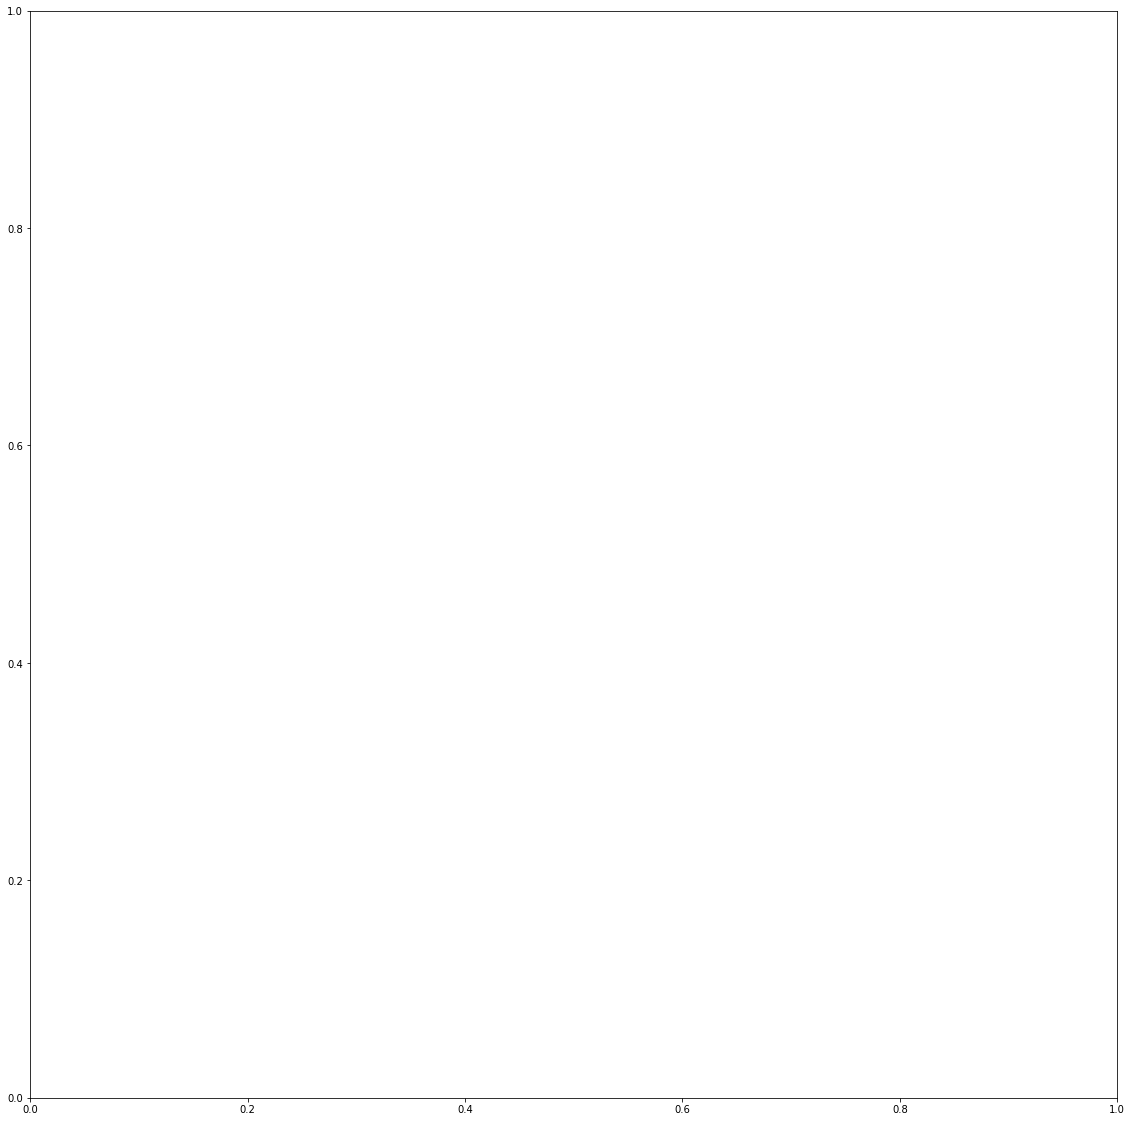

In [221]:
# Hispanic subset, coloured by birth region
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images'

fname = 'HRS_HISP_UMAP_PC10_NC2_NN15_MD0.5_201844193148'
proj = np.loadtxt(os.path.join(proj_dir, fname))

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, aspect=1)

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_born[pop])

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
plt.close()

KeyError: 'ENC'

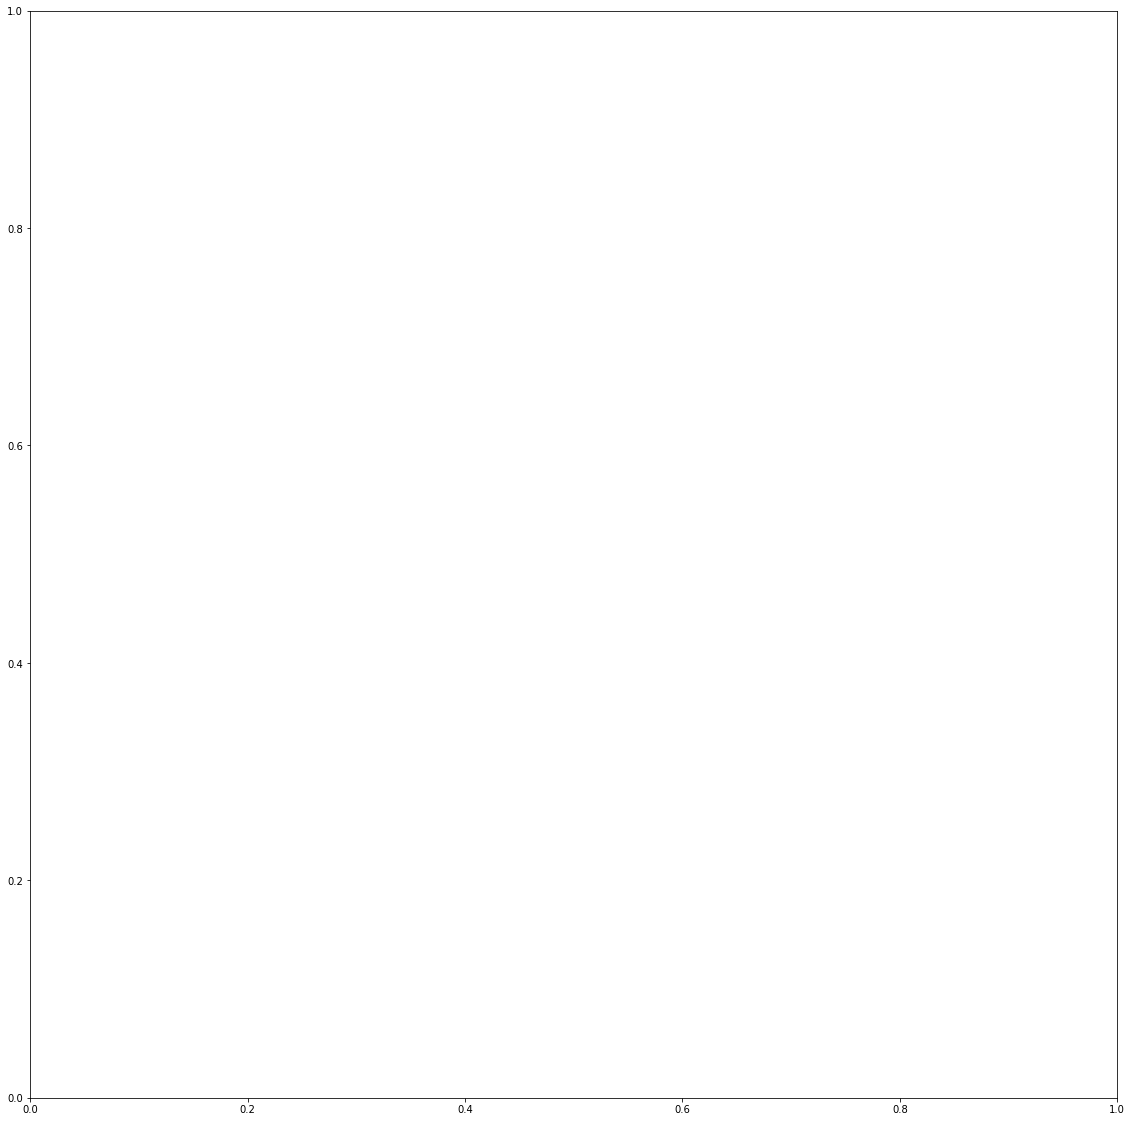

In [235]:
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images'

fname = 'HRS_HISP_PC1_PC2'
proj = hrs_data_dict['Hispanic']
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, aspect=1)

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_race_hisp_mex[pop])

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
fig.savefig(os.path.join(out_dir, fname + '_RACE_HISP_MEX.jpeg'),format='jpeg')
plt.close()

In [236]:
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images'

fname = 'HRS_HISP_PC1_PC2'
proj = hrs_data_dict['Hispanic']
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, aspect=1)

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_born[pop])

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
fig.savefig(os.path.join(out_dir, fname + '_BORN.jpeg'),format='jpeg')
plt.close()

In [209]:
#HRS_UMAP_PC10_NN15_MD0.5_2018330153123
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images/other'

fname = 'HRS_UMAP_PC10_NN15_MD0.5_2018330153123'
proj= np.loadtxt(os.path.join(proj_dir, fname))
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, aspect=1)

#for pop in sorted(eth_proxy_set):
for pop in ['W_N_N','B_N_N','W_H_M','W_H_O','O_N_N','O_H_M','O_H_O','B_H_O','W_H_U']:
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_race_hisp_mex[pop])

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
fig.savefig(os.path.join(out_dir, fname + '_RACE_HISP_MEX.jpeg'),format='jpeg')
plt.close()

In [ ]:
W_N_N 9442
B_N_N 1620
W_H_M 615
W_H_O 376
O_N_N 189
O_H_M 90
O_H_O 89
B_H_O 32
W_H_U 1

In [208]:
for e in eth_proxy_set:
    print(e, proj[indices_of_population_members_hrs[e]].shape[0])

W_H_O 376
O_H_O 89
B_N_N 1620
B_H_O 32
O_N_N 189
W_H_U 1
W_N_N 9442
O_H_M 90
W_H_M 615


# Admixture plots for Hispanic population
Goal: Create an admixture bar plot.

Need: Admixture for Hispanics (somewhere in here....) and indices and birth regions. Cluster or highlight mountain region Hispanic individuals

In [106]:
# Admixture data is stored in hrs_joined

hrs_joined_hispanic = hrs_joined.loc[hrs_joined['HispanicStatus']=='Hispanic']
hrs_joined_hispanic=hrs_joined_hispanic.sort_values(['BirthRegionName','ADMIX3'])
hrs_joined_hispanic.reset_index(drop=True)

,IndID,FamID,BirthYear,HispanicStatus,DetailedHispanicStatus,Race_HRS,BirthRegionNum,BirthRegionName,AgeRange,Gender,Race_dbGaP,ID,ADMIX1,ADMIX2,ADMIX3
0,161302994,161302994,1933,Hispanic,Other,White,3,East_North_Central,70-74,M,Not_AfrAm,161302994,0.011083,0.987105,0.000527
1,161288850,161288850,1926,Hispanic,Other,White,3,East_North_Central,75-79,M,Not_AfrAm,161288850,0.019844,0.979161,0.000577
2,161276872,161276872,1953,Hispanic,Other,White,3,East_North_Central,55-59,F,Not_AfrAm,161276872,0.001548,0.996758,0.001508
3,161386386,161386386,1948,Hispanic,Other,White,3,East_North_Central,55-59,F,Not_AfrAm,161386386,0.001628,0.996194,0.002085
4,161205345,161205345,1941,Hispanic,Other,White,3,East_North_Central,60-64,M,Not_AfrAm,161205345,0.000705,0.995891,0.003331
5,161249845,161249845,1949,Hispanic,Other,White,3,East_North_Central,55-59,F,Not_AfrAm,161249845,0.002663,0.991936,0.004479
6,161279342,161279342,1927,Hispanic,Mexican-American,White,3,East_North_Central,80+,F,Not_AfrAm,161279342,0.013090,0.878272,0.106248
7,161210095,161210095,1954,Hispanic,Other,White,3,East_North_Central,<55,F,Not_AfrAm,161210095,0.161406,0.725584,0.110934
8,161334553,161334553,1951,Hispanic,Mexican-American,White,3,East_North_Central,55-59,F,Not_AfrAm,161334553,0.019723,0.828163,0.150034
9,161346019,161346019,1951,Hispanic,Mexican-American,White,3,East_North_Central,55-59,F,Not_AfrAm,161346019,0.012701,0.823944,0.160460


In [107]:
afr_bars = [i for i in hrs_joined_hispanic['ADMIX1']]
eur_bars = [i for i in hrs_joined_hispanic['ADMIX2']]
oth_bars = [i for i in hrs_joined_hispanic['ADMIX3']]

In [168]:
np.where(hrs_joined_hispanic['BirthRegionName']=='Mountain')[0]

array([   0,    1,   11,   12,   13,   27,   37,   45,   54,   71,   76,
         84,   89,   91,  105,  119,  127,  130,  155,  176,  197,  201,
        224,  226,  233,  268,  294,  299,  310,  315,  319,  321,  328,
        339,  343,  346,  349,  352,  353,  361,  367,  383,  394,  396,
        402,  416,  430,  434,  440,  447,  463,  470,  472,  476,  484,
        486,  488,  498,  501,  509,  513,  516,  525,  526,  533,  541,
        548,  557,  560,  563,  564,  579,  580,  582,  589,  591,  600,
        605,  606,  623,  624,  629,  639,  643,  645,  656,  658,  675,
        680,  684,  688,  693,  710,  715,  719,  726,  734,  741,  787,
        792,  804,  809,  823,  826,  830,  841,  856,  876,  898,  908,
        910,  923,  938,  941,  946,  947,  949,  957,  980,  984,  992,
        995, 1004, 1011, 1014, 1070, 1073, 1075, 1093, 1122, 1132, 1138,
       1143, 1163, 1165, 1167, 1175])

In [109]:
bar_width = 1.0
inds = [i for i in range(0, hrs_joined_hispanic.count()[0])]

([<matplotlib.axis.XTick at 0x1a57876cc0>,
 <a list of 8 Text xticklabel objects>)

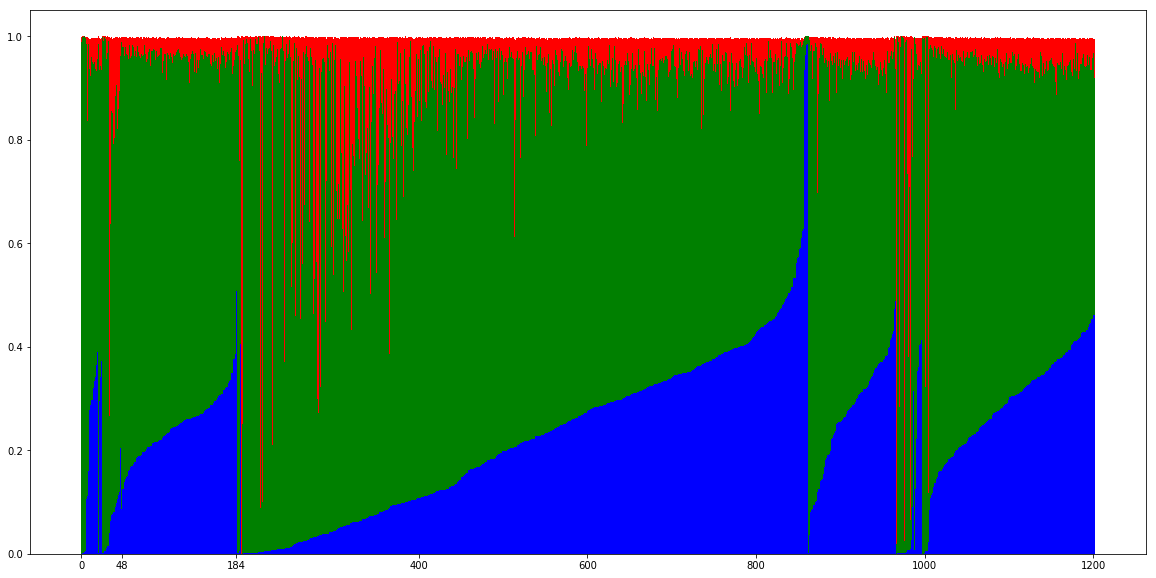

In [115]:
plt.figure(figsize=(20,10))
plt.bar(inds, oth_bars, color='blue', width=bar_width)
plt.bar(inds, eur_bars, bottom = oth_bars, color='green', width=bar_width)
#plt.bar(inds, eur_bars, bottom = [i+j for i,j in zip(afr_bars, oth_bars)], color='green', width=bar_width)
plt.bar(inds, afr_bars, bottom = [i+j for i,j in zip(oth_bars, eur_bars)],color='red', width=bar_width)
plt.xticks([0,48,184,400,600,800,1000,1200])

In [147]:
# We can take this one step further. Use HRS_HISP_UMAP_PC10_NC2_NN15_MD0.5_201844193148 and find all instances of y<-10
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
fname = 'HRS_HISP_UMAP_PC10_NC2_NN15_MD0.5_201844193148'

proj= np.loadtxt(os.path.join(proj_dir, fname))
proj_df = pd.DataFrame(proj)
proj_df.columns=['UMAP_x','UMAP_y']

In [148]:
# Reload the dataframe (sorting screwed it up)
hrs_joined_hispanic = hrs_joined.loc[hrs_joined['HispanicStatus']=='Hispanic']
hrs_joined_hispanic_umap = pd.concat([hrs_joined_hispanic.reset_index(drop=True), proj_df], axis=1)

In [149]:
hrs_joined_hispanic_umap=hrs_joined_hispanic_umap.sort_values(['BirthRegionName','ADMIX3'])
hrs_joined_hispanic_umap=hrs_joined_hispanic_umap.reset_index(drop=True)

In [156]:
cluster = hrs_joined_hispanic_umap.loc[(hrs_joined_hispanic_umap['BirthRegionName']=='Mountain') & (hrs_joined_hispanic_umap['UMAP_y'] < -10)]

In [157]:
cluster

,IndID,FamID,BirthYear,HispanicStatus,DetailedHispanicStatus,Race_HRS,BirthRegionNum,BirthRegionName,AgeRange,Gender,Race_dbGaP,ID,ADMIX1,ADMIX2,ADMIX3,UMAP_x,UMAP_y
51,161284433,161284433,1939,Hispanic,Other,White,8,Mountain,65-69,M,Not_AfrAm,161284433,0.035786,0.824051,0.138273,6.305502,-16.390560
52,161234663,161234663,1921,Hispanic,Mexican-American,White,8,Mountain,80+,F,Not_AfrAm,161234663,0.027538,0.827088,0.143702,4.501736,-15.200147
53,161380158,161380158,1940,Hispanic,Mexican-American,White,8,Mountain,65-69,M,Not_AfrAm,161380158,0.018517,0.834202,0.145352,4.726237,-16.076406
55,161281177,161281177,1937,Hispanic,Other,White,8,Mountain,70-74,M,Not_AfrAm,161281177,0.034125,0.812039,0.150782,5.572817,-16.973462
58,161248393,161248393,1937,Hispanic,Other,Other,8,Mountain,65-69,F,Not_AfrAm,161248393,0.041375,0.788372,0.168394,5.621951,-16.935139
59,161247828,161247828,1934,Hispanic,Other,White,8,Mountain,70-74,F,Not_AfrAm,161247828,0.025848,0.802507,0.169764,6.276265,-16.327912
60,161274008,161274008,1939,Hispanic,Mexican-American,White,8,Mountain,65-69,M,Not_AfrAm,161274008,0.036633,0.790153,0.170405,5.534967,-16.235781
61,161239585,161239585,1925,Hispanic,Other,White,8,Mountain,80+,M,Not_AfrAm,161239585,0.015663,0.811539,0.170480,5.831194,-15.677688
62,161216924,161216924,1939,Hispanic,Other,Other,8,Mountain,65-69,F,Not_AfrAm,161216924,0.018540,0.804324,0.173794,5.266220,-16.689210
64,161341611,161341611,1917,Hispanic,Mexican-American,White,8,Mountain,80+,F,Not_AfrAm,161341611,0.025788,0.793670,0.177686,4.302396,-15.762927


In [160]:
cluster.count()

IndID                     80
FamID                     80
BirthYear                 80
HispanicStatus            80
DetailedHispanicStatus    80
Race_HRS                  80
BirthRegionNum            80
BirthRegionName           80
AgeRange                  80
Gender                    80
Race_dbGaP                80
ID                        80
ADMIX1                    80
ADMIX2                    80
ADMIX3                    80
UMAP_x                    80
UMAP_y                    80
dtype: int64

# Sandbox

Plot admixture colours on ethnic subsets

In [34]:
hrs_joined_sorted = hrs_joined.values.tolist()
temp_list = [h[-3:] for h in hrs_joined_sorted]
hrs_joined_sorted_array = np.array(temp_list)
hrs_joined_sorted_array = (255*hrs_joined_sorted_array).astype(np.int64)
hrs_joined_sorted_array.shape

color_dict_admix = defaultdict(int)
for i in range(0, len(hrs_joined_sorted)):
    color_dict_admix[i] = '#%02x%02x%02x' % (hrs_joined_sorted_array[i][0],
                                             hrs_joined_sorted_array[i][1],
                                             hrs_joined_sorted_array[i][2])

color_list_admix = list()
for i in range(0, len(hrs_joined_sorted)):
    color_list_admix.append('#%02x%02x%02x' % (hrs_joined_sorted_array[i][0],
                                             hrs_joined_sorted_array[i][1],
                                             hrs_joined_sorted_array[i][2]))

In [35]:
hrs_data_dict['Hispanic'].shape

(1203, 200)

In [36]:
hispanic_index_list = hrs_df_sorted.loc[(hrs_df_sorted['HispanicStatus'] == 'Hispanic')].index.values.tolist()

In [37]:
color_list_hispanic = [color_list_admix[i] for i in hispanic_index_list]

In [40]:
len(color_list_hispanic)

1203

In [219]:
# Import TSNE PC projections from file and export HTML
temp_proj = np.loadtxt('/Volumes/Stockage/alex/hrs/projections/HRS_HISP_UMAP_PC10_NC2_NN15_MD0.5_201844193148')
p = figure(plot_width=1500, plot_height=800)
p.title.text = 'Test Hispanic admixture values'

p.circle(temp_proj[:,0], temp_proj[:,1], color = color_list_hispanic, size=5)

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file('test2' + '.html',title='test')

show(p)

In [220]:
# Import TSNE PC projections from file and export HTML
#temp_proj = np.loadtxt('/Volumes/Stockage/alex/hrs/projections/HRS_PCA_hispanic.eigenvec')
temp_proj = hrs_data_dict['Hispanic']
p = figure(plot_width=1500, plot_height=800)
p.title.text = 'Test Hispanic PC values'

p.circle(temp_proj[:,0], temp_proj[:,1], color = color_list_hispanic, size=5)

p.legend.location = "top_left"

p.legend.click_policy="hide"

output_file('test3' + '.html',title='test')

show(p)

temp_proj.shape

(1203, 200)

In [39]:
len(color_list_admix)

12454

In [53]:
indices_of_population_members_hrs.keys()

dict_keys(['B_N', 'W_N', 'O_H', 'W_H', 'B_H', 'O_N'])

In [261]:
#hrs_create_int_html(hrs_data_dict['Hispanic'], 'HRS Hispanic', of, 'HRS Hispanic PCs')

temp_array = hrs_data_dict['Hispanic']

component_1_id = 4
component_2_id = 5

p = figure(plot_width=1500, plot_height=800)
p.title.text = 'HRS Hispanic PCs ' + str(component_1_id+1) + ' and ' + str(component_2_id+1)

for pop in sorted(eth_proxy_set):
    proj_pop = temp_array[indices_of_population_members_hrs[pop]]
    p.circle(proj_pop[:,component_1_id], proj_pop[:,component_2_id], legend=pop_dict[pop],
             color = color_dict_born[pop])

p.legend.location = "top_left"

p.legend.click_policy="hide"

fname = 'HRS_HISP_PC' + str(component_1_id+1) + '_' + str(component_2_id+1) + '_BORN'

output_file(fname + '.html',title='HRS Hispanic PCs ' + str(component_1_id+1) + ' and ' + str(component_2_id+1))

save(p)

'/Users/alex/Documents/Ethnicity/HRS_HISP_PC5_6_BORN.html'

In [249]:
temp_proj = np.loadtxt('/Volumes/Stockage/alex/hrs/projections/HRS_HISP_UMAP_PC10_NC2_NN15_MD0.5_201844193148')
of = '/Users/alex/Documents/Ethnicity/HRS_HISP_UMAP_PC10_NC2_NN15_MD0.5_201844193148'
hrs_create_int_html(temp_proj, 'HRS Hispanic', of, 'HRS Hispanic PCA-UMAP')

Create a grid of PC groups to look at Hispanic clustering

In [ ]:
proj = hrs_data_dict['Hispanic']

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, aspect=1)

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.6, color=color_dict_born[pop])

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.15), fontsize=12,markerscale=3)
fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
plt.close()

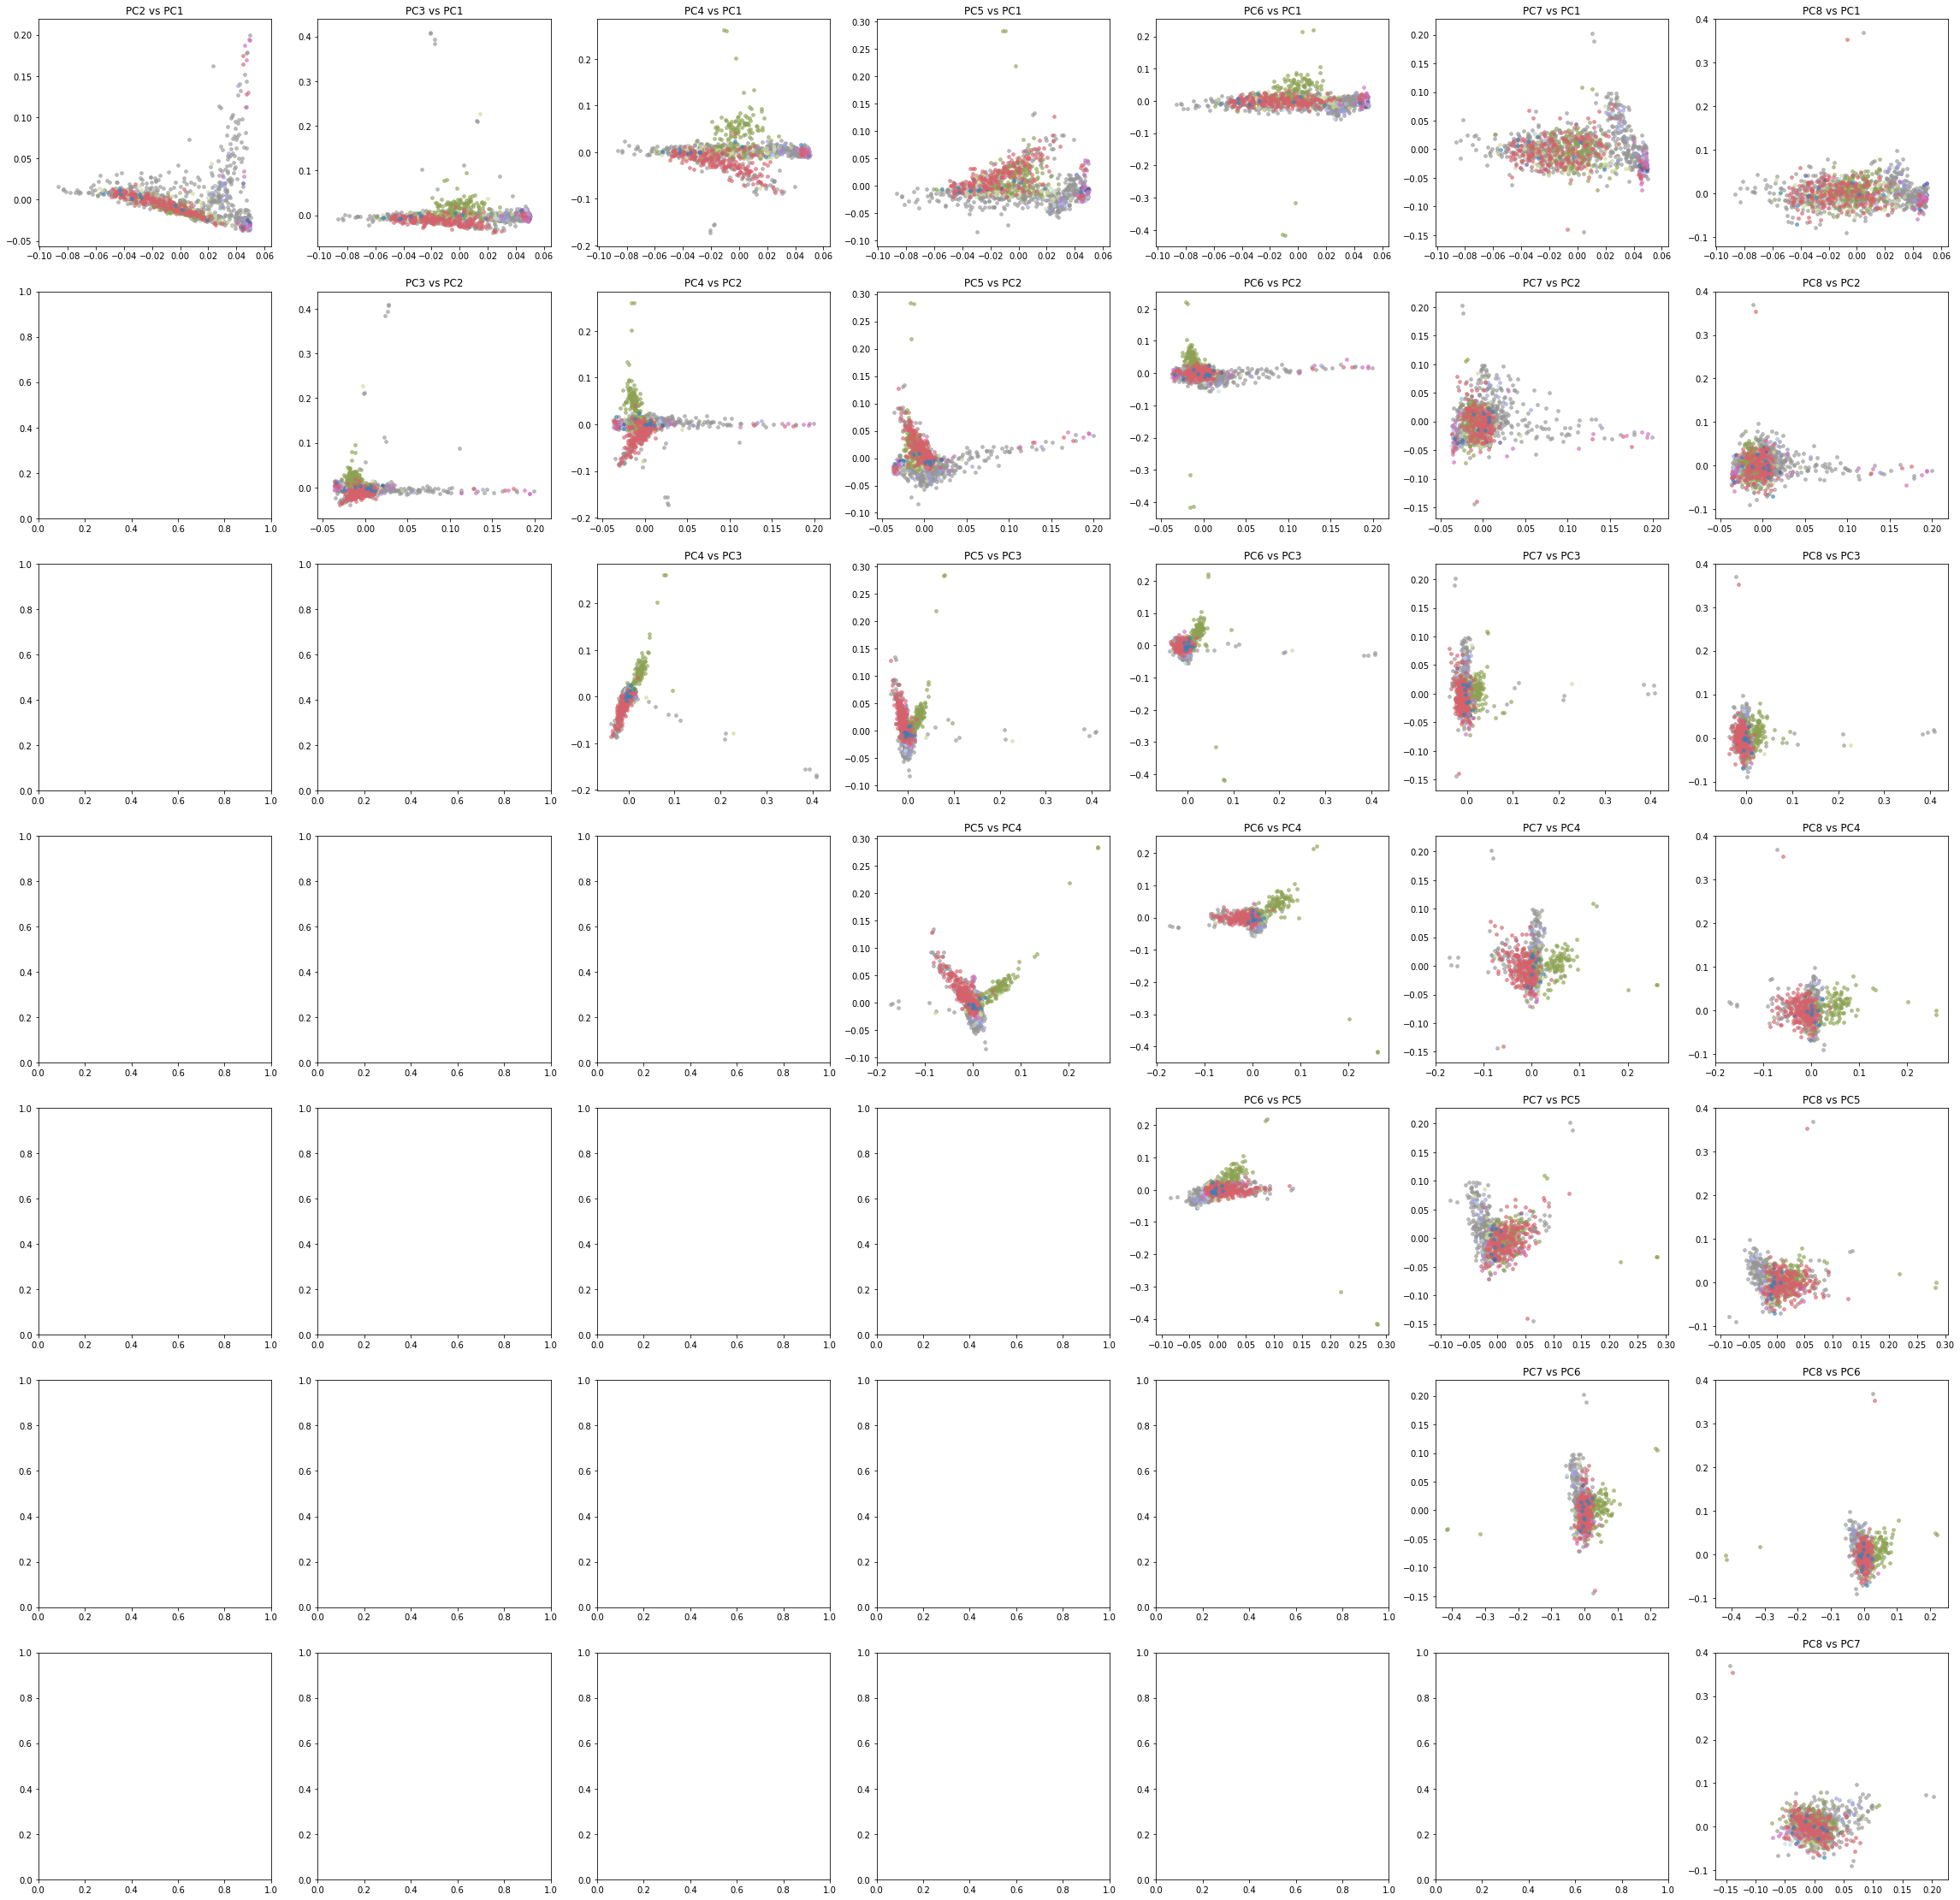

In [330]:
proj = hrs_data_dict['Hispanic']

gridsize = 7
f, axarr = plt.subplots(gridsize,gridsize,figsize=(40,40))

for i in range(0,gridsize):
    for j in range(0,gridsize):
        if i<=j:
            for pop in eth_proxy_set:
                temp_proj = proj[indices_of_population_members_hrs[pop]]
                axarr[i,j].scatter(temp_proj[:,i], temp_proj[:,j+1], alpha=0.6, s=14, color=color_dict_born[pop])
                axarr[i,j].set_title('PC' + str(j+2) + ' vs PC' + str(i+1))
            
    
plt.legend(ncol=3,loc='lower center', bbox_to_anchor=[-1,-1], bbox_transform=plt.gcf().transFigure, fontsize=12,markerscale=3)   
plt.show()

In [333]:
# Generate images (not HTML)
proj_dir = '/Volumes/Stockage/alex/hrs/projections'
out_dir = '/Volumes/Stockage/alex/hrs/images/grid'

fname = 'HRS_HISP_UMAP_PC7_NC2_NN15_MD0.5_201844193148'

proj = np.loadtxt(os.path.join(proj_dir, fname))

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, aspect=1)

for pop in sorted(eth_proxy_set):
    temp_proj = proj[indices_of_population_members_hrs[pop]]
    ax.scatter(temp_proj[:,0], temp_proj[:,1], label=pop_dict[pop], alpha=0.8, color=color_dict_born[pop])

ax.legend(ncol=3,loc='lower center', bbox_to_anchor=(0.55,-0.1), fontsize=12,markerscale=3)
fig.savefig(os.path.join(out_dir, fname + '.jpeg'),format='jpeg')
plt.close()